# K Nearest Neighbors

Практическая работа по методу k-ближайших соседей.

## Загрузка библиотек



In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_style('whitegrid')
%matplotlib inline

## Загрузка данных

Данные взяты с сайта Kaggle.com: https://www.kaggle.com/abcsds/pokemon

In [2]:
data = pd.read_csv("data/Pokemon.csv", index_col=0).reset_index(drop=True)

In [3]:
data.head()

,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


# Exploratory Data Analysis - описательное исследование данных

Начнем рассмотрение данных с пропущенных данных, затем посмотрим на распределение категориальных и числовых данных.

## Missing Data - пропущенные данные

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 12 columns):
Name          800 non-null object
Type 1        800 non-null object
Type 2        414 non-null object
Total         800 non-null int64
HP            800 non-null int64
Attack        800 non-null int64
Defense       800 non-null int64
Sp. Atk       800 non-null int64
Sp. Def       800 non-null int64
Speed         800 non-null int64
Generation    800 non-null int64
Legendary     800 non-null bool
dtypes: bool(1), int64(8), object(3)
memory usage: 69.6+ KB


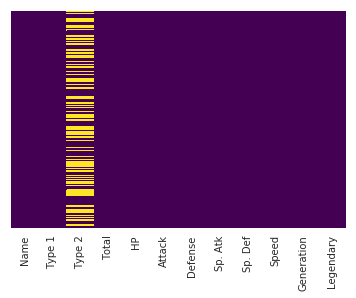

In [5]:
sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.show()

In [6]:
data.isnull().sum()

Name            0
Type 1          0
Type 2        386
Total           0
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64

В наших данных мало пропусков - всего одна колонка. 

Есть несколько способов бороться с пропусками в категориальных данных:
* Удалить такие колонки;
* Заполнить новыми значениями, тем самым создав дополнительную группу.

Поступим вторым способом.

In [7]:
data.loc[data['Type 2'].isnull(), 'Type 2'] = 'NoneType'

## Распределения

Посмотрим на таргет, а потом на остальные колонки.

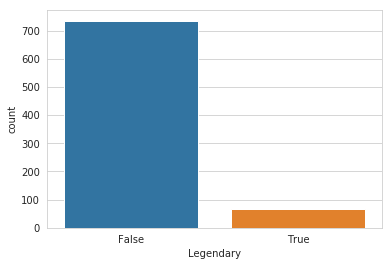

In [8]:
fig = sns.countplot(x='Legendary', data=data)
plt.show()

Виден сильный перекос в таргете, поэтому придется с осторожностью подойти к подбору метрики качества.

Ниже распределения остальных категориальных фич и числовых.

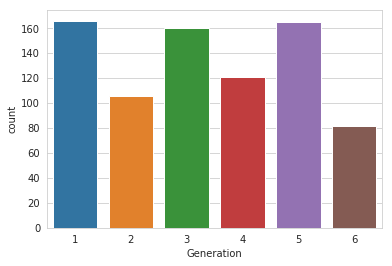

In [9]:
fig = sns.countplot(x='Generation', data=data)
plt.show()

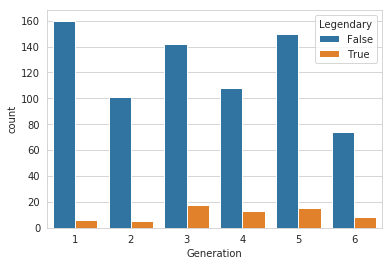

In [10]:
fig = sns.countplot(x='Generation', hue='Legendary', data=data)

plt.show()

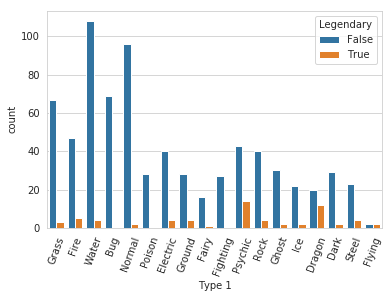

In [11]:
fig = sns.countplot(x='Type 1', hue='Legendary', data=data)
fig.set_xticklabels(fig.get_xticklabels(), rotation=70)
plt.show()

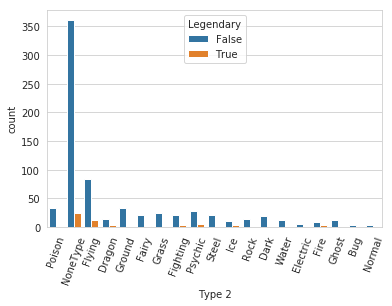

In [12]:
fig = sns.countplot(x='Type 2', hue='Legendary', data=data)
fig.set_xticklabels(fig.get_xticklabels(), rotation=70)
plt.show()

In [13]:
num_cols = [col for col in data.columns if data[col].dtype == 'float64' or data[col].dtype == 'int64']
need_cols = num_cols+['Legendary']

In [16]:
# sns.pairplot(data[need_cols], hue='Legendary')
# plt.show()

/root/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


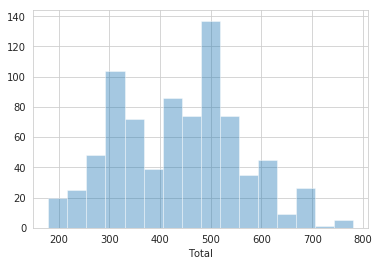

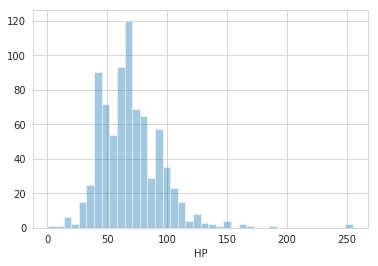

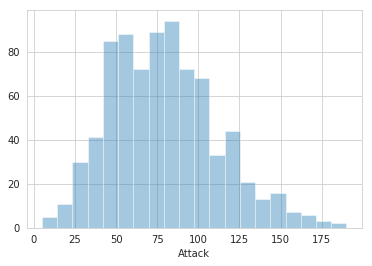

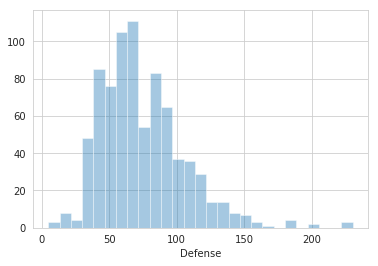

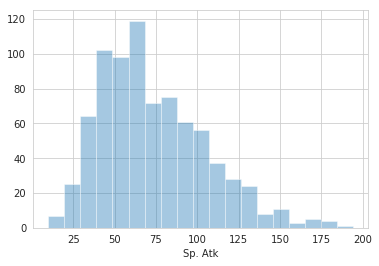

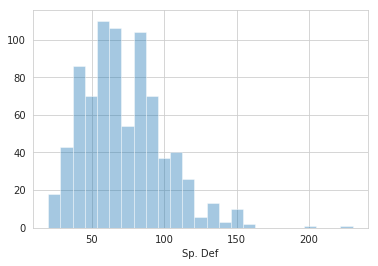

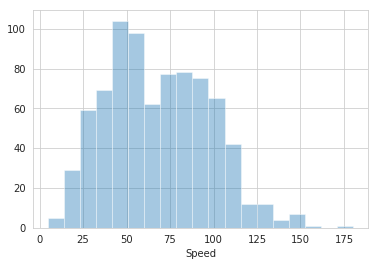

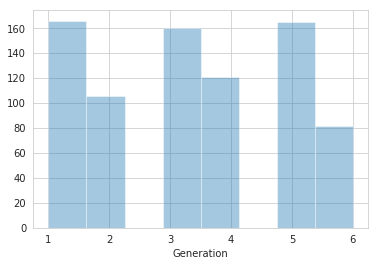

In [17]:
for col in num_cols:
    sns.distplot(data[col], kde=False)
    plt.show()

## Преобразуем  категориальные данные в числовые.

В метрических алгоритмах есть так называемое проклятье размерности. Это когда размерность пространства признаков настолько большая, что для алгоритма все объекты равноудалены и классификация или регрессия по ним затруднительна. 

Поэтому при преобразовании категориальных признаков нам не хотелось бы сильно увеличивать размерность пространства признаков.

Есть два основынх способа преобразования категориальных переменных:
* Дамми-переменные, когда каждому значению категориальной переменной соответствует своя колонка и единичка ставится в соответствующую колонку, если у объекта данное значение категориального признака. Если в переменной 3 значения, то колонок тоже будет три, и 1 будут стоять в соответствующий колонке.
* Каждому значению категориальной переменной присвоить свое число. Самый простой способ - это LabelEncoding.

Для нас лучше начать с LabelEncoding, так как таким способом новых фичей мы не будем добавлять. А в случае с дамми переменными пришлось бы еще много колонок добавить. 

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 12 columns):
Name          800 non-null object
Type 1        800 non-null object
Type 2        800 non-null object
Total         800 non-null int64
HP            800 non-null int64
Attack        800 non-null int64
Defense       800 non-null int64
Sp. Atk       800 non-null int64
Sp. Def       800 non-null int64
Speed         800 non-null int64
Generation    800 non-null int64
Legendary     800 non-null bool
dtypes: bool(1), int64(8), object(3)
memory usage: 69.6+ KB


Всего у нас 3 нечисловые фичи, помимо таргета, который легко преобразуется в 0 и 1. Но с Name мы не будем сейчас разбираться. Хотя самые интересующуюся могут применить к Name методы NLP. Например, TF-IDF. Поэтому пока просто выкинем Name.

In [19]:
data.drop('Name', inplace=True, axis=1)

In [20]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
data['Type 1'] = encoder.fit_transform(data['Type 1'])
data['Type 2'] = encoder.fit_transform(data['Type 2'])

## Train Test Split

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(data, data['Legendary'],
                                                    test_size=0.3, random_state=42)

## Скалирование признаков.

Метрические методы крайне чувствительны к масштабу признаков, так как большим по масштабу признакам будет придано большее значение, ведь они вносят больший вклад в совокупное расстояние. Хотя, на самом деле, они могут быть и не важны. Поэтому хорошо было бы привести их к одному порядку.

In [23]:
from sklearn.preprocessing import MinMaxScaler

In [24]:
scaler = MinMaxScaler()

In [25]:
num_cols = [col for col in X_train.columns if X_train[col].dtype == 'float64' or X_train[col].dtype == 'int64']

In [26]:
scaler.fit(X_train[num_cols])

MinMaxScaler(copy=True, feature_range=(0, 1))

In [27]:
scaled_features = scaler.transform(X_train[num_cols])
X_test = scaler.transform(X_test[num_cols])

In [28]:
df_feat = pd.DataFrame(scaled_features, columns=num_cols)
X_test = pd.DataFrame(X_test, columns=num_cols)
df_feat.head()

,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation
0,1.000000,0.888889,0.508333,0.340426,0.459459,0.555556,0.205882,0.214286,0.322581,0.4
1,0.647059,0.666667,0.575000,0.191489,0.297297,0.466667,0.705882,0.357143,0.387097,0.6
2,0.941176,0.444444,0.446667,0.165957,0.567568,0.644444,0.205882,0.138095,0.193548,1.0
3,0.117647,0.388889,1.000000,0.361702,0.945946,0.422222,1.000000,0.380952,0.709677,0.4
4,0.235294,0.666667,0.505000,0.319149,0.351351,0.302222,0.500000,0.333333,0.354839,0.0


## Построение модели KNN

Начнем с простого случая одного соседа.

In [29]:
from sklearn.neighbors import KNeighborsClassifier

In [30]:
knn = KNeighborsClassifier(n_neighbors=1)

In [31]:
knn.fit(df_feat, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [32]:
pred = knn.predict_proba(X_test)[:, 1]

In [33]:
pred

array([1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

## Предсказание и оценка модели

In [34]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score

In [35]:
print(confusion_matrix(y_test, pred))

[[218   7]
 [  5  10]]


In [36]:
print('Precision (class False) {:.2f} Recall (class False) {:.2f}\
      \nPrecision (class True)  {:.2f} Recall (calss True)  {:.2f}'.format(218/223, 218/225, 10/17, 10/15))

Precision (class False) 0.98 Recall (class False) 0.97      
Precision (class True)  0.59 Recall (calss True)  0.67


In [37]:
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

      False       0.98      0.97      0.97       225
       True       0.59      0.67      0.62        15

avg / total       0.95      0.95      0.95       240



In [38]:
print('{:.2f} {:.2f}'.format((218+10)/(218+10+7+5), accuracy_score(y_test, pred)))

0.95 0.95


In [39]:
print('{:.2f}'.format(roc_auc_score(y_test, pred)))

0.82


## Выбор K

In [40]:
error_rate = []

for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(df_feat, y_train)
    pred_i = knn.predict_proba(X_test)[:, 1]
    error_rate.append(roc_auc_score(y_test, pred_i))

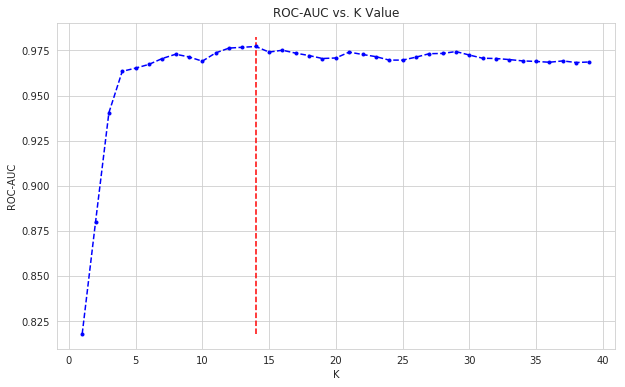

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 40),error_rate, color='blue', linestyle='dashed', marker='.')
plt.title('ROC-AUC vs. K Value')
plt.xlabel('K')
plt.ylabel('ROC-AUC')
errors = list(zip(range(1,100), error_rate))
errors = sorted(errors, key=lambda tup: tup[1], reverse=True)
vert_line = errors[0][0]
plt.vlines(x=vert_line, ymin=min(error_rate), ymax=max(error_rate)+0.005, color='red', linestyles='dashed')
plt.show()

In [42]:
errors = list(zip(range(1,100), error_rate))
errors = sorted(errors, key=lambda tup: tup[1], reverse=True)
errors[:5]

[(14, 0.9771851851851853),
 (13, 0.9767407407407407),
 (12, 0.9762962962962962),
 (16, 0.975111111111111),
 (29, 0.9743703703703703)]

# Домашнее задание

Вам необходимо  построить модель с максимальном скором метрики roc_auc.

Кросс-валидацией пользоваться не стоит.

Ограничения: не более 50 соседей.

Советы для возможных улучшений:
* Сравнить разные метрики: metrics = ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
* Перебирать параметры для меделей, например, можно подобрать оптимальный p для метрики minkowski
* Удаление или генерация колонок тоже может привести к росту скора.

Задание направлено на то, чтобы вы поработали с ноутбуком, попробовали генерацию новых фич и исследовали разные параметры модели.

Решением является ноутбук, который работает с начала и до конца без ошибок. 

Балл за домашнее задание будет распределяться в соотношении с вашим местом в рейтинге решивших задание. Так что лучше постараться достичь как можно большего скора.

### Решения высылать на valencia13@mail.ru с пометкой ECON2018_homework_1

# Отличная работа!

Не ленитесь пробовать новое!